## Import libraries

In [1]:
import os
import pyxdf # xdf file importation
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from my_functions import *
# library for creating filters
from scipy.signal import butter, iirnotch, filtfilt, welch, periodogram
#%matplotlib widget

### Ensure that the root directory is the project directory
In some cases, the root directory may not be the project directory. This is usually the case when the notebook is run from a subdirectory of the project directory.

In [2]:
# if pwd is SRC  change to root
print("Current working directory: ", os.getcwd())
if os.path.basename(os.getcwd()) == "SRC":
    os.chdir("..")
print("Current working directory: ", os.getcwd())
print(os.path.basename(os.getcwd()))

Current working directory:  c:\Users\iWiss\Documents\GitHub\Stage_Signal_Physio\SRC
Current working directory:  c:\Users\iWiss\Documents\GitHub\Stage_Signal_Physio
Stage_Signal_Physio


In [3]:
plt.close("all")  # close all figure windows

## Initialization

 ### File selection and signal loading (Ramdani data)

In [4]:
# Define the xdf file path
FILENAME = "EEG_1channel_1000_Hz.csv"
# FILENAME = "EEG_1channel_1000Hz.txt"
# FILENAME="020_DesMar_20211129_1_c.xdf"
# path=os.path.normpath("../DAT/Input/001_MolLud_20201112_1_c.xdf")
path = os.path.normpath("DAT/INPUT/"+FILENAME)


In [5]:
EEG_amplitudes= np.loadtxt(path,dtype=float,delimiter=",")

Srate=1000
N=len(EEG_amplitudes)

In [6]:
EEG_amplitudes_centered=EEG_amplitudes-np.mean(EEG_amplitudes)

### Import of matlab estimation results

In [7]:
matlab_results_filename="MATLAB_PSD_res_EEG_chan_0_EEG_1channel_1000_Hz.csv"
#Not for plot, but for distribution comparison (abs diff, rms)
PSD_fft_matlab,PSD_p_matlab,PSD_w_matlab=import_psd_results2(psd_results_file_name=matlab_results_filename) 

./DAT/OUTPUT/Matlab_PSD_Results/MATLAB_PSD_res_EEG_chan_0_EEG_1channel_1000_Hz.csv <class 'str'>


## Plots (see function details at end of notebook)

(10201,)
N:  10201
duration:  10.201
time_vector shape:  (10201,)
signal_frequency_vector before crop len:5101,half_val: 250.09803921568627
signal_frequency_vector last freq : 500.0


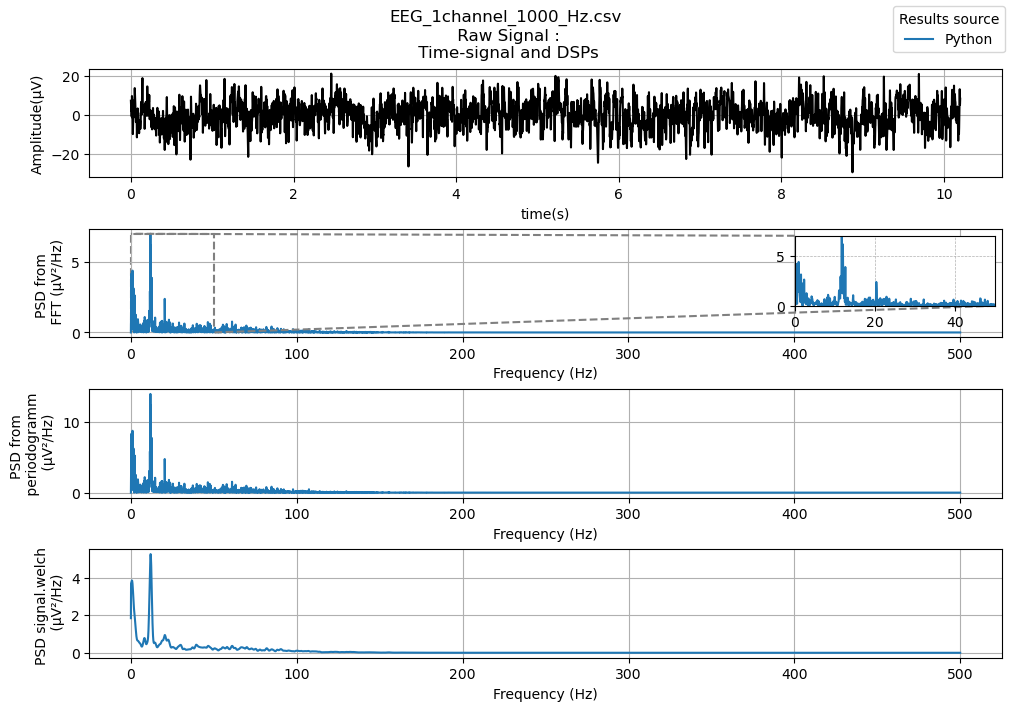

In [8]:
print(EEG_amplitudes.shape)
_=plot_single_signal_time_dsps(fig_number=1, signal= EEG_amplitudes, sample_rate=Srate, fig_title=FILENAME + "\n Raw Signal")

N:  10201
duration:  10.201
time_vector shape:  (10201,)
signal_frequency_vector before crop len:5101,half_val: 250.09803921568627
signal_frequency_vector last freq : 500.0
./DAT/OUTPUT/Matlab_PSD_Results/MATLAB_PSD_res_EEG_chan_0_EEG_1channel_1000_Hz.csv <class 'str'>
len psd matlab fft:5101


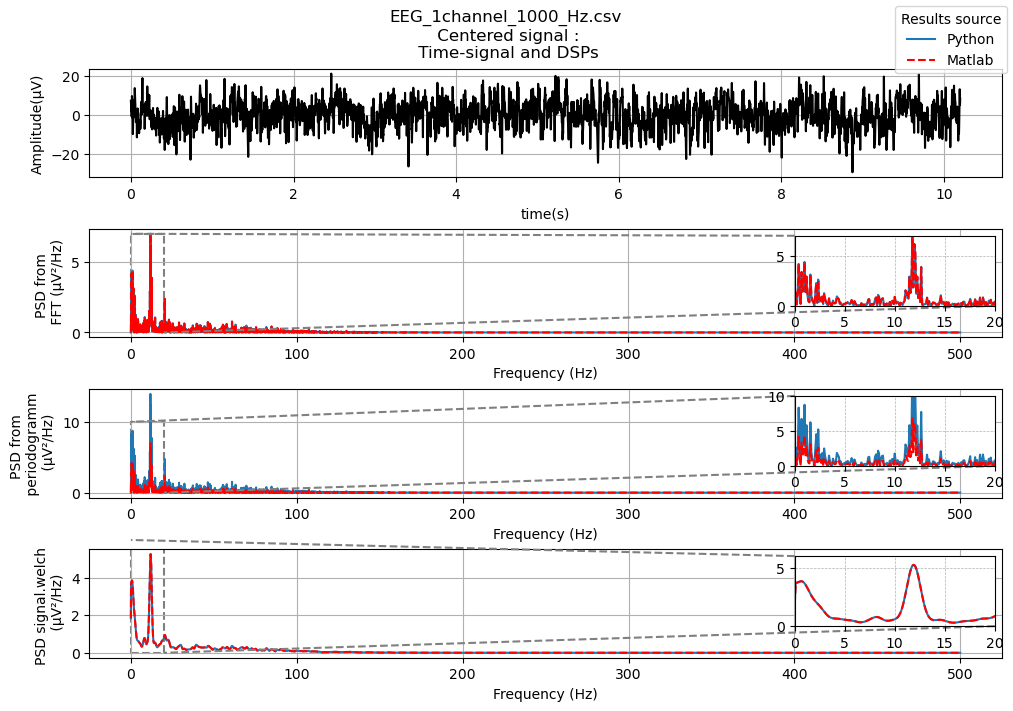

In [9]:
PSD_results=plot_single_signal_time_dsps(fig_number=2, signal= EEG_amplitudes_centered, sample_rate=Srate, 
                                         fig_title=FILENAME+"\n Centered signal",external_results=matlab_results_filename)


### PSD estimation result comparison  matlab vs python over 3 methods (squared FFT, periodogram(),welch method)

In [10]:
print(np.unique(PSD_results["Python_PSD_results"]["PSD_FFT"]["frequencies"] == PSD_results["Matlab_PSD_results"]["PSD_FFT"]["frequencies"]))
print(np.unique(PSD_results["Python_PSD_results"]["PSD_P"]["frequencies"]   == PSD_results["Matlab_PSD_results"]["PSD_P"]["frequencies"]))
print(np.unique(PSD_results["Python_PSD_results"]["PSD_W"]["frequencies"]   == PSD_results["Matlab_PSD_results"]["PSD_W"]["frequencies"]))


[False  True]
[False  True]
[False  True]


- we can find identical and differing frequency values for each method between python and matlab

In [11]:
print(np.unique(PSD_results["Python_PSD_results"]["PSD_FFT"]["psds"] == PSD_results["Matlab_PSD_results"]["PSD_FFT"]["psds"]))
print(np.unique(PSD_results["Python_PSD_results"]["PSD_P"]["psds"]   == PSD_results["Matlab_PSD_results"]["PSD_P"]["psds"]))
print(np.unique(PSD_results["Python_PSD_results"]["PSD_W"]["psds"]   == PSD_results["Matlab_PSD_results"]["PSD_W"]["psds"]))

[False  True]
[False]
[False  True]


- we can find identical and differing PSD values for each method between python and matlab

<u>CCL:</u> Python and Matlab results are similar, but to what extent?

### Difference in PSD estimation methods according to language (python vs matlab)

### Root mean square error (RMSE) of the difference between the python and matlab distributions for each PSD estimation method

In [12]:
rms_fft=rms(PSD_results["Python_PSD_results"]["PSD_FFT"]["psds"],PSD_results["Matlab_PSD_results"]["PSD_FFT"]["psds"],"rms_fft")
rms_p=rms(PSD_results["Python_PSD_results"]["PSD_P"]["psds"],PSD_results["Matlab_PSD_results"]["PSD_P"]["psds"],"rms_p")
rms_w=rms(PSD_results["Python_PSD_results"]["PSD_W"]["psds"],PSD_results["Matlab_PSD_results"]["PSD_W"]["psds"],"rms_w")

#difference between python's PSD estimation via fft vs python's welch function
rms_python_w_vs_fft=rms(PSD_results["Python_PSD_results"]["PSD_FFT"]["psds"],PSD_results["Python_PSD_results"]["PSD_W"]["psds"],"rms_python_w_vs_fft") 

rms_fft =  2.4733283808304315e-16  (µV²/Hz)
rms_p =  0.249800345032278  (µV²/Hz)
rms_w =  3.310000807880911e-16  (µV²/Hz)
rms_python_w_vs_fft =  0.2401652639922246  (µV²/Hz)


<u>Observation on PSD estimation via FFT</u>

Check rounding of values during exportation from matlab:
-default settings of write to tables 
- rms_fft =  2.4733283808304315e-16  (µV²/Hz)
-

<u>Observation on welch</u>

Check window parameter for scipy equivalent to matlabs:
- with window parameter set to window="hamm"               : rms = 0.08288641753310991
- with window parameter set to window=signal.hamming(1000) : rms = 0.08278399915754926

Detrending:
- without specifying detrend (with hamming(1000) ): rms_w = 0.08278399915754926
- with detrend=False option                       : rms_w = 3.310000807880911e-16



CCL : python scipy.welch must use detrend=False. if argument is not specified, it defaults to  "constant" and removes the constent component, whereas in matlab there is not default detrending of the signal.



<u>Observation on periodogram</u>

Scipy periodogram function relies on the welch function, ~~which has a default overlap of 50%~~(not here cf git code) unlike matlab's function which is based on fft function and has a default overlap value of 0%.

Since scipy's periodogram is a welch with no overlap, and matlab's periodogram is an fft (of the autocor?) if we compare python's PSDs obtained via welch and fft we should have similar rms:
- rms_p =  0.249800345032278  (µV²/Hz) (python vs matlab  periodogram)
- rms_python_w_vs_fft =  0.2401652639922246  (µV²/Hz) (python fft vs python welch)

CCL: the "high" rmse between the matlab and python periodogram functions in comparison to the two other method of PSD estimation (welch, fft) may be due to the different algorithm behind the periodogram() functions

https://stackoverflow.com/questions/17130795/periodogram-in-octave-matlab-vs-scipy/17310061#17310061

https://github.com/scipy/scipy/blob/28697172c55070d61ee916f9d784c6a4ffa49191/scipy/signal/_spectral_py.py#L157-L294

https://gist.github.com/jonbrennecke/11148249#file-periodogram-m-L21



In [13]:
absdiff_fft=abs_distance(PSD_results["Python_PSD_results"]["PSD_FFT"]["psds"],PSD_results["Matlab_PSD_results"]["PSD_FFT"]["psds"])
absdiff_p=abs_distance(PSD_results["Python_PSD_results"]["PSD_P"]["psds"],PSD_results["Matlab_PSD_results"]["PSD_P"]["psds"])
absdiff_w=abs_distance(PSD_results["Python_PSD_results"]["PSD_W"]["psds"],PSD_results["Matlab_PSD_results"]["PSD_W"]["psds"])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


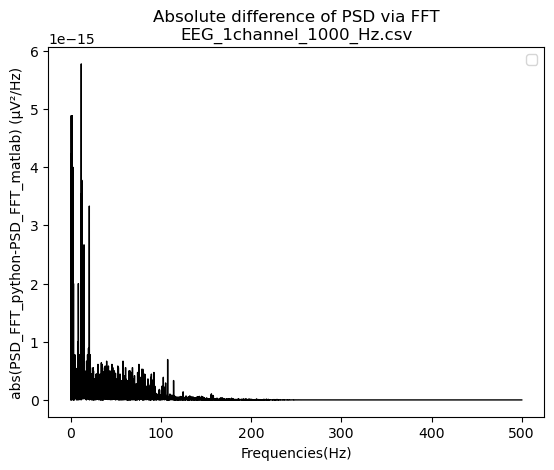

In [14]:
single_plot(FILENAME,fig_number=3,
            x=PSD_results["Python_PSD_results"]["PSD_FFT"]["frequencies"],y=absdiff_fft,
            fig_title="Absolute difference of PSD via FFT",
            ylabel="abs(PSD_FFT_python-PSD_FFT_matlab) (µV²/Hz)",
            xlabel="Frequencies(Hz)")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


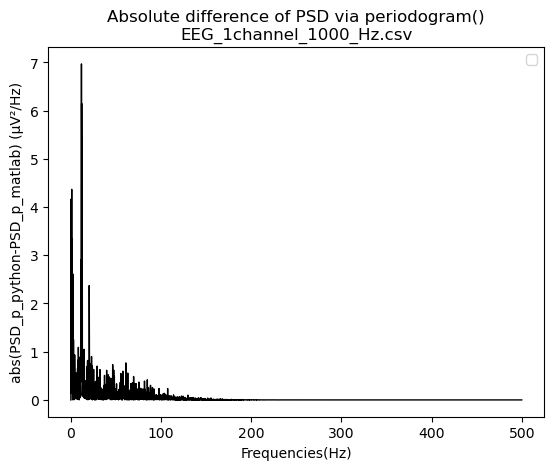

In [15]:
single_plot(FILENAME,fig_number=4,
            x=PSD_results["Python_PSD_results"]["PSD_P"]["frequencies"],y=absdiff_p,
            fig_title="Absolute difference of PSD via periodogram()",
            ylabel="abs(PSD_p_python-PSD_p_matlab) (µV²/Hz)",
            xlabel="Frequencies(Hz)")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


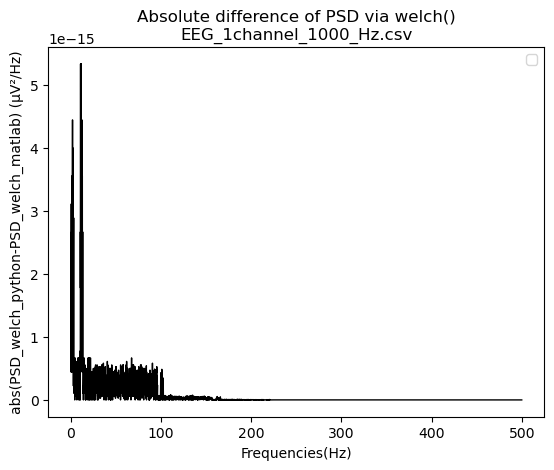

In [16]:
single_plot(FILENAME,fig_number=5,
            x=PSD_results["Python_PSD_results"]["PSD_W"]["frequencies"],y=absdiff_w,
            fig_title="Absolute difference of PSD via welch()",
            ylabel="abs(PSD_welch_python-PSD_welch_matlab) (µV²/Hz)",
            xlabel="Frequencies(Hz)")